# SPICE Input File Plotter
Workspace to figure out a quick way to sketch out the environment of a spice input file. 

In [27]:
%matplotlib tk
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os
import pathlib as pth
sys.path.append('/home/jleland/Coding/Projects/flopter')
import flopter.spice.inputparser as inp

In [9]:
input_file_dir = pth.Path('/home/jleland/Spice/spice2/bin/inputs/')
# os.chdir(input_file_dir)
input_file = input_file_dir / 'lowdens_anglescan' / 'flush_tiltscan1-90.inp'
print(str(input_file))

/home/jleland/Spice/spice2/bin/inputs/lowdens_anglescan/flush_tiltscan1-90.inp


In [10]:
inputparser = inp.InputParser()
with open(input_file, 'r') as inpf:
    inputparser.read_file(inpf)

In [11]:
shape_section_labels = {'rectangle', 'triangle', 'circle'}
# shape_sections = [section for section in inputparser.sections() if any([shpsec in section for shpsec in shape_section_labels])]
shape_sections = {}
for shape in shape_section_labels:
    shape_section = [inputparser[section] for section in inputparser.sections() if shape in section]
    shape_sections[shape] = shape_section
print(shape_sections)

{'rectangle': [<Section: rectangle0>, <Section: rectangle1>, <Section: rectangle2>], 'circle': [], 'triangle': []}


In [12]:
for shape_sec in shape_sections['rectangle']:
    print(f"y: {shape_sec['ylow']}, {shape_sec['yhigh']} \t\t z: {shape_sec['zlow']}, {shape_sec['zhigh']}")
for shape_sec in shape_sections['triangle']:
    print(f"y: {shape_sec['ya']}, {shape_sec['yb']}, {shape_sec['yc']} \t z: {shape_sec['za']}, {shape_sec['zb']}, {shape_sec['zc']}")

y: 0, 68 		 z: 0, 52
y: 488, 556 		 z: 0, 52
y: 128, 428 		 z: 0, 52


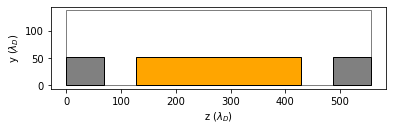

In [15]:
fig, ax = plt.subplots()

geometry = inputparser['geom']
sim_objects = [plt.Rectangle((0, 0), int(geometry['Ly']), int(geometry['Lz']), fc='w', ec='gray', zorder=-2)] 

for shape_sec in shape_sections['rectangle']:
    rect_colour = 'orange' if 'probe' in shape_sec['name'].lower() else 'gray'
    rect_width = int(shape_sec['yhigh']) - int(shape_sec['ylow'])
    rect_height = int(shape_sec['zhigh']) - int(shape_sec['zlow'])
    
    sim_objects.append(plt.Rectangle((int(shape_sec['ylow']), int(shape_sec['zlow'])), rect_width, rect_height, fc=rect_colour, ec='k'))
    
for shape_sec in shape_sections['triangle']:
    triangle_colour = 'orange' if 'probe' in shape_sec['name'].lower() else 'gray'
    triangle_points = [[shape_sec['ya'], shape_sec['za']], [shape_sec['yb'], shape_sec['zb']], [shape_sec['yc'], shape_sec['zc']]]
    triangle_points = [(int(tp[0]), int(tp[1])) for tp in triangle_points]
    
    sim_objects.append(plt.Polygon(triangle_points, fc=triangle_colour, ec='k'))
    
for so in sim_objects:
    ax.add_patch(so)

ax.axis('scaled')
ax.set_xlabel(r'z ($\lambda_D$)')
ax.set_ylabel(r'y ($\lambda_D$)')
ax.autoscale()

In [30]:
fig, axes = plt.subplots(2, 2, sharex='col', sharey='col')
colours = ['orange', 'blue']
inputs = ['flush_tiltscan1-90.inp', 'angledtip_tiltscan1-90.inp']

lowdens_dir = pth.Path('/home/jleland/Data/external/spice/')
fit_data_filename = 'lowdens_fitdata.csv'

fit_df = pd.read_csv(lowdens_dir / fit_data_filename, index_col=0)

for i, tip in enumerate(['flush', 'angled']):
    input_file = input_file_dir / 'lowdens_anglescan' / inputs[i]
    
    inputparser = inp.InputParser()
    with open(input_file, 'r') as inpf:
        inputparser.read_file(inpf)

    shape_section_labels = {'rectangle', 'triangle', 'circle'}
    shape_sections = {}
    for shape in shape_section_labels:
        shape_section = [inputparser[section] for section in inputparser.sections() if shape in section]
        shape_sections[shape] = shape_section
    print(shape_sections)

    ax = axes[i][0]

    geometry = inputparser['geom']
    sim_objects = [plt.Rectangle((0, 0), int(geometry['Ly']), int(geometry['Lz']), fc='w', ec='gray', zorder=-2)] 

    for shape_sec in shape_sections['rectangle']:
        rect_colour = colours[i] if 'probe' in shape_sec['name'].lower() else 'gray'
        rect_width = int(shape_sec['yhigh']) - int(shape_sec['ylow'])
        rect_height = int(shape_sec['zhigh']) - int(shape_sec['zlow'])

        sim_objects.append(plt.Rectangle((int(shape_sec['ylow']), int(shape_sec['zlow'])), rect_width, rect_height, fc=rect_colour, ec='k'))

    for shape_sec in shape_sections['triangle']:
        triangle_colour = colours[i] if 'probe' in shape_sec['name'].lower() else 'gray'
        triangle_points = [[shape_sec['ya'], shape_sec['za']], [shape_sec['yb'], shape_sec['zb']], [shape_sec['yc'], shape_sec['zc']]]
        triangle_points = [(int(tp[0]), int(tp[1])) for tp in triangle_points]

        sim_objects.append(plt.Polygon(triangle_points, fc=triangle_colour, ec='k'))

    for so in sim_objects:
        ax.add_patch(so)

    probe_str = f'{tip} probe \n\n'
    
    ax.axis('scaled')
    ax.set_xlabel(r'z ($\lambda_D$)')
    ax.set_ylabel(probe_str + r'y ($\lambda_D$)')
    ax.autoscale()

    ax_t = axes[i][1]
    
    probe_df = fit_df.loc[fit_df['probe'] == tip]
    ax_t.errorbar('angle', 'temp', fmt='x', color=colours[i], yerr='d_temp', data=probe_df, label=tip)
    ax_t.axhline(y=1.0, linestyle='dashed', linewidth='0.8', color='gray')
    
    ax_t.set_ylabel(r'$T_{e, P}$ / $T_{e, SE}$')
    ax_t.set_xlabel(r'Incidence angle  ($^{\circ}$)')
    ax_t.legend()

{'rectangle': [<Section: rectangle0>, <Section: rectangle1>, <Section: rectangle2>], 'circle': [], 'triangle': []}
{'rectangle': [<Section: rectangle0>, <Section: rectangle1>, <Section: rectangle2>], 'circle': [], 'triangle': [<Section: triangle0>]}
